In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import lob_for_futures as lobFut
from lob_for_futures import *
import os
import matplotlib.pyplot as plt

from dateutil.parser import parse
from pandas.tseries.offsets import BDay
import pickle as pkl
import fnmatch
import pickle
import datetime as dt
from datetime import timedelta
import glob
import fathon
from fathon import fathonUtils as fu
import itertools
import pyinform as pyinf
import pingouin as pig
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon
from scipy.special import kl_div
import time
import matplotlib.ticker as mtick
dataFolder = lobFut.dataFolder
quotes = [f for f in os.listdir(dataFolder) if str('_quotes') in f]
trades = [f for f in os.listdir(dataFolder) if str('_trades') in f]

# symbolIdx = 0

symbols = [f.split("_")[0] for f in quotes]
#
# symbol = sorted(symbols)[symbolIdx]
# print(symbol)
# quotesFileCh = os.path.join(dataFolder, quotes[symbolIdx])
# tradesFileCh = os.path.join(dataFolder, trades[symbolIdx])
#
# # get common Dates
# quotesDates = sorted([f.split(".csv")[0] for f in os.listdir(quotesFileCh)])
# tradesDates = sorted([f.split(".csv")[0] for f in os.listdir(tradesFileCh)])
# intersectionDates = list(set(quotesDates).intersection(tradesDates))

trades_cols = ['size', 'time', 'type', 'value']
experimentsDestination = '/media/ak/T7/MFDFA Experiments'
plt.style.use(os.path.join('/home/ak/.config/matplotlib','latexstyle3.mplstyle'))

In [4]:
# Lets create a function that shifted your dataframe first before calling the corr(). 
# Let us break down what we hope to accomplish, and then translate that into code. 
# For each hour (row) and for a given feature (column) I would like to find the value 
# for that feature N hours prior. 
# For each value of N (1-6 in our case) I want to make a new column 
# for that feature representing the Nth prior hour's measurement.

def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1)
    return df

def get_test_stats(bar_types,bar_returns,test_func,*args,**kwds):
    
    dct = {bar:(int(bar_ret.shape[0]), test_func(bar_ret,*args,**kwds)) 
           for bar,bar_ret in zip(bar_types,bar_returns)}
    df = (pd.DataFrame.from_dict(dct)
          .rename(index={0:'sample_size',1:f'{test_func.__name__}_stat'})
          .T)
    return df

In [5]:
class volatilityEstimation(object):

    def __init__(self, df, tick_window=20, clean=True):
        self.df = df
        self.tick_window = tick_window
        self.mu_1 = np.sqrt((2 / np.pi))
        self.mu_43 = 2 ** (2 / 3) * scipy.special.gamma(7 / 6) ** scipy.special.gamma(1 / 2) ** (-1)
        self.clean = True  # set to true to remove nans at the beginning of the period
        self.trading_seconds_btc = 86400
        self.trading_seconds_futures = 23400
        self.column_open = 'micro_price_open'
        self.column_high = 'micro_price_high'
        self.column_low = 'micro_price_low'
        self.column_close = 'micro_price_close'

        self.log_hl = (df[str(self.column_high)] / df[str(self.column_low)]).apply(np.log)
        self.log_co = (df[str(self.column_close)] / df[str(self.column_open)]).apply(np.log)
        # median sampling frequency

        self.z = pd.Series([((x.hour * 60 + x.minute) * 60 + x.second) 
              for x in pd.to_datetime(df['QuoteTime_open'])]).diff().fillna(0).astype('float64')

        self.clean_arrival_rates = np.asarray(
            self.z[(self.z > self.z.quantile(0.003)) & (self.z < self.z.quantile(0.97))].dropna()).astype('float64')
        # clean arrival rates after i remove all the outliers
        self.mean_sampling_frequency = np.mean(np.asarray(self.clean_arrival_rates))

    def arrival_rates(self):

        clean_arrival_rates = np.asarray(self.z[(self.z > self.z.quantile(0.003)) & (self.z < self.z.quantile(0.97))].dropna()).astype('float64')
        # clean arrival rates after i remove all the outliers

        return clean_arrival_rates

    def M_parameter(self):
        """
        normalised sampling frequency for adjustments
        """

        M_btc = self.trading_seconds_btc / self.mean_sampling_frequency
        M_futures = self.trading_seconds_futures / self.mean_sampling_frequency

        return [M_btc, M_futures]

    def garmanKlass(self, trading_periods):

        rs = 0.5 * self.log_hl ** 2 - (2 * np.log(2) - 1) * self.log_co ** 2

        def f(v):
            return (trading_periods * v.mean()) ** 0.5

        result = rs.rolling(window=self.tick_window, center=False).apply(func=f)

        if self.clean:
            return result.dropna()
        else:
            return result

    def parkinson(self, trading_periods, clean=True):

        rs = (1.0 / (4.0 * np.log(2.0))) * (self.df[str(self.column_high)] / self.df[str(self.column_close)]).apply(
            np.log) ** 2.0

        def f(v):
            return trading_periods * v.mean() ** 0.5

        result = rs.rolling(window=self.tick_window, center=False).apply(func=f)

        if self.clean:
            return result.dropna()
        else:
            return result

    def bipower_variation(self, rollingWindow=5):
        '''
        Bipower Variation (BV) is the sum of the product of absolute time series returns
        :param column: price column
        :return: returns bivariate variation
        Barnhorf - Nielse & Shephard 2004 & 2006
        '''
        bv = self.mu_1 ** (-2) * (
            (self.log_hl.abs() * self.log_hl.shift(1).abs()).fillna(0).rolling(rollingWindow).sum())

        if self.clean:
            return bv.dropna()
        else:
            return bv

    def tripower_quarticity(self, rollingWindow=5, sampling_param=0):
        """
        using M for BTC here - change sampling param to 1 for everything else
        """
        tpq = self.M_parameter()[sampling_param] * self.mu_43 ** (-3) * ((self.log_hl.abs() ** (
                4 / 3) * self.log_hl.shift(1).abs() ** (4 / 3) * self.log_hl.shift(2).abs() ** (4 / 3)).rolling(
            rollingWindow).sum().fillna(0))

        if self.clean:

            return tpq.dropna()
        else:
            return tpq

    def realised_variance(self, rollingWindow=5):
        """
        realised variance - andersen & bollerselv -1998
        """

        realvar = (self.log_hl ** 2).rolling(rollingWindow).sum().fillna(0)

        if self.clean:
            return realvar.dropna()
        else:
            return realvar

    def realised_absolute_variation(self, rollingWindow=5, sampling_param=0):
        """
        realised absolute variation - Forsberg & Ghysels 2007
        using M for BTC here - change sampling param to 1 for everything else
        """

        realabsovar = self.mu_1 ** (-2) * self.M_parameter[sampling_param] ** (-0.5) * self.log_hl.rolling(
            rollingWindow).sum().fillna(0)

        return realabsovar

    def realised_skewness_kurtosis(self, rollingWindow=15, sampling_param=0):

        """
        set the rolling window to 10-15
        sampling param for BTC ~ 0
        """

        rm3 = (self.log_hl ** 3).rolling(rollingWindow).sum().fillna(0)
        rm4 = (self.log_hl ** 4).rolling(rollingWindow).sum().fillna(0)

        rs = np.sqrt(self.M_parameter()[sampling_param]) * (
                rm3 / self.realised_variance(rollingWindow=rollingWindow)) ** (3 / 2)
        rk = self.M_parameter()[sampling_param] * (rm4 / self.realised_variance(rollingWindow=rollingWindow)) ** 2

        return rs, rk

    def jumps_test(self, rollingWindow, sampling_param=0):
        """
        Jump test by Huang and Tauchen 2005
        adopted by repo: RealisedQuantities
        """

        j1 = (np.log(self.realised_variance(rollingWindow=rollingWindow)) - np.log(
            self.bipower_variation(rollingWindow=rollingWindow)))
        j2 = (((self.mu_1 ** -4) + 2 * (self.mu_1 ** -2) - 5) /
              (self.M_parameter()[0] * self.tripower_quarticity(rollingWindow=rollingWindow,
                                                                sampling_param=sampling_param)
               * (self.bipower_variation(rollingWindow=rollingWindow) ** -2)))

        j = j1 / (j2 ** 0.5)

        return (j.abs() >= stats.norm.ppf(0.995)) * 1  # can also look at 0.999)*

    def relative_jump_measure(self, rollingWindow, sampling_param=0):

        nominator = (self.realised_variance(rollingWindow=rollingWindow)
                     - self.bipower_variation(rollingWindow=rollingWindow))

        measure_to_return = nominator / self.bipower_variation(rollingWindow=rollingWindow)

        return measure_to_return

    def negative_semivariance(self, x):
        """
        input: returns
        negative realised semivariance
        Barndorff- Nielsen
        """
        return x.apply(lambda x: (x ** 2)) * (x < 0).sum()

    def positive_semivariance(self, x):
        """
        input: returns
        positive realised semivariance
        Barndorff- Nielsen
        """
        return x.apply(lambda x: (x ** 2)) * (x > 0).sum()

    def signed_jump_variation(self, x):

        sjv = self.positive_semivariance(x) - self.negative_semivariance(x)
        sjv_p = sjv * (sjv > 0)
        sjv_n = sjv * (sjv < 0)

        return sjv_p, sjv_n

    def continuous_discontinuous_quadratic_variance(self):

        """
        seperate continuous and discontinuous parts of quadratic variation

        """
        pass


class descriptiveStats(object):

    def __init__(self, df):
        self.df = df
        self.column_open = 'micro_price_open'
        self.column_high = 'micro_price_high'
        self.column_low = 'micro_price_low'
        self.column_close = 'micro_price_close'
        self.log_hl = (df[str(self.column_high)] / df[str(self.column_low)]).apply(np.log)
        self.log_co = (df[str(self.column_close)] / df[str(self.column_open)]).apply(np.log)

    def base_descriptive_stats(self):
        desc_stats = dict()
        desc_stats['median_hl'] = np.median(self.log_hl)
        desc_stats['mean_co'] = np.median(self.log_co)
        desc_stats['quantile_95_hl'] = self.log_hl.quantile(0.95)
        desc_stats['quantile_95_co'] = self.log_co.quantile(0.95)
        desc_stats['q3_75_hl'] = self.log_hl.quantile(0.75)
        desc_stats['q3_75_co'] = self.log_co.quantile(0.75)
        desc_stats['q1_25_hl'] = self.log_hl.quantile(0.25)
        desc_stats['q1_25_co'] = self.log_co.quantile(0.25)
        desc_stats['outlier_lower_limit_hl'] = desc_stats['q1_25_hl'] - 1.5 * (
                desc_stats['q3_75_hl'] - desc_stats['q1_25_hl'])
        desc_stats['outlier_upper_limit_hl'] = desc_stats['q3_75_hl'] + 1.5 * (
                desc_stats['q3_75_hl'] - desc_stats['q1_25_hl'])
        desc_stats['lower_limit_outliers'] = self.log_hl[self.log_hl > desc_stats['outlier_lower_limit_hl']].count()
        desc_stats['upper_limit_outliers'] = self.log_hl[self.log_hl > desc_stats['outlier_upper_limit_hl']].count()
        desc_stats['total_outliers'] = desc_stats['lower_limit_outliers'] + desc_stats['upper_limit_outliers']
        
        return desc_stats


In [6]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [7]:
mpl.get_configdir()
# plot parametrisations
latex_styles = os.listdir(mpl.get_configdir())
latex_styles

plt.style.use(os.path.join(mpl.get_configdir(), latex_styles[1]))
figures_destination = '/home/ak/Documents/Research/Papers/StylisedFactsPaper/figures'

In [8]:
## functions to be tested

In [9]:
# Lets create a function that shifted your dataframe first before calling the corr(). 
# Let us break down what we hope to accomplish, and then translate that into code. 
# For each hour (row) and for a given feature (column) I would like to find the value 
# for that feature N hours prior. 
# For each value of N (1-6 in our case) I want to make a new column 
# for that feature representing the Nth prior hour's measurement.

def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1)
    return df

def get_test_stats(bar_types,bar_returns,test_func,*args,**kwds):
    
    dct = {bar:(int(bar_ret.shape[0]), test_func(bar_ret,*args,**kwds)) 
           for bar,bar_ret in zip(bar_types,bar_returns)}
    df = (pd.DataFrame.from_dict(dct)
          .rename(index={0:'sample_size',1:f'{test_func.__name__}_stat'})
          .T)
    return df

In [10]:

if __name__ == '__main__':
    # params i need for fathon
    winSizes = fu.linRangeByStep(5, 50)
    revSeg = True
    qs = np.arange(-3, 4, 0.1)
    polOrd = 3
    # load all teh dataframes at once with this
    start = time.time()
    print(start)
    # go through all the dataframes and take out n, f and h, h_ intercept
    # somehow one list comprehension blows up in memory

    h_dict = defaultdict(dict)

    symbolIdx = 2

    symbol = sorted(symbols)[symbolIdx]
    print(symbol)
    quotesFileCh = os.path.join(dataFolder, quotes[symbolIdx])
    tradesFileCh = os.path.join(dataFolder, trades[symbolIdx])

    # get common Dates
    quotesDates = sorted([f.split(".csv")[0] for f in os.listdir(quotesFileCh)])
    tradesDates = sorted([f.split(".csv")[0] for f in os.listdir(tradesFileCh)])
    intersectionDates = list(set(quotesDates).intersection(tradesDates))

    trades_cols = ['size', 'time', 'type', 'value']

    # params for the clocks

    calendar_resample_freq = "300S"
    trade_volume_width = 100
    ticks_width = 100
    usd_volume_width = 100
    dates_choice = intersectionDates[0:3]

    testClass = DataLoader(data_location=dataFolder,
                           symbol=symbol,
                           dates=dates_choice,
                           use_columns=trades_cols,
                           calendar_resample=calendar_resample_freq,
                           trade_volume_width=trade_volume_width,
                           ticks_width=ticks_width,
                           usd_volume_width=usd_volume_width)

    hash_of_file = "_".join(
        (str(symbol), "volume_width", str(trade_volume_width), "calendar_resample", str(calendar_resample_freq)))

    # load data
    input_dict = testClass.load_and_format_data()

    tick_bar_dfs = []
    volume_bar_dfs = []
    usd_volume_bar_dfs = []
    calendar_bar_dfs = []
    dates = list(input_dict.keys())

    bar_returns = dict()
    
    

2021-11-28 19:26:38,336 DataLoader  INFO Loading data for:20180608


1638127598.334773
FV1
/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180608.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180608.csv


2021-11-28 19:26:40,767 DataLoader  INFO Loading data for:20181003


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20181003.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20181003.csv


2021-11-28 19:26:42,626 DataLoader  INFO Loading data for:20180525


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180525.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180525.csv


In [6]:
dates

['20180614', '20181008', '20180910']

In [7]:
bars_dicts = defaultdict(dict)
for date in dates:
        df = testClass.load_and_format_data()[str(date)]
        input_dict = testClass.get_bars(df)
        tick_bar_df = testClass.get_concat_data(testClass._bars_dict)['tick_bars']
        volume_bar_df = testClass.get_concat_data(testClass._bars_dict)['volume_bars']
        usd_volume_bar_df = testClass.get_concat_data(testClass._bars_dict)['usd_volume_bars']
        calendar_bar_df = testClass.get_concat_data(testClass._bars_dict)['calendar_bars']
        vr = returns(volume_bar_df.micro_price_close).replace([np.inf, -np.inf], 0)  # volume
        tr = returns(tick_bar_df.micro_price_close).replace([np.inf, -np.inf], 0)  # tick
        dr = returns(usd_volume_bar_df.micro_price_close).dropna().replace([np.inf, -np.inf], 0)  # usd volume
        df_ret = returns(calendar_bar_df.micro_price_close).dropna().replace([np.inf, -np.inf], 0)  # calendar
        bar_returns[date] = {'tick': tr,
                             'volume': vr,
                             'dollar': dr,
                             'calendar': df_ret}
        bars_dicts[date]['tick'] = tick_bar_df
        bars_dicts[date]['volume'] = volume_bar_df
        bars_dicts[date]['calendar'] = calendar_bar_df
        bars_dicts[date]['dollar'] =  usd_volume_bar_df
        


2021-10-30 23:09:42,258 DataLoader  INFO Loading data for:20180614


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180614.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180614.csv


2021-10-30 23:09:44,639 DataLoader  INFO Loading data for:20181008


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20181008.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20181008.csv


2021-10-30 23:09:45,402 DataLoader  INFO Loading data for:20180910


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180910.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180910.csv


2021-10-30 23:09:46,894 DataLoader  INFO Calculating calendar clock
2021-10-30 23:09:48,725 DataLoader  INFO Calculating volume clock
2021-10-30 23:12:21,092 DataLoader  INFO Calculating tick clock
2021-10-30 23:12:32,613 DataLoader  INFO Calculating usd volume clock
2021-10-30 23:29:15,335 DataLoader  INFO Loading data for:20180614


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180614.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180614.csv


2021-10-30 23:29:17,656 DataLoader  INFO Loading data for:20181008


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20181008.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20181008.csv


2021-10-30 23:29:18,519 DataLoader  INFO Loading data for:20180910


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180910.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180910.csv


2021-10-30 23:29:20,006 DataLoader  INFO Calculating calendar clock
2021-10-30 23:29:20,925 DataLoader  INFO Calculating volume clock
2021-10-30 23:29:55,725 DataLoader  INFO Calculating tick clock
2021-10-30 23:29:58,449 DataLoader  INFO Calculating usd volume clock
2021-10-30 23:34:40,030 DataLoader  INFO Loading data for:20180614


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180614.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180614.csv


2021-10-30 23:34:42,381 DataLoader  INFO Loading data for:20181008


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20181008.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20181008.csv


2021-10-30 23:34:43,132 DataLoader  INFO Loading data for:20180910


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180910.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180910.csv


2021-10-30 23:34:44,615 DataLoader  INFO Calculating calendar clock
2021-10-30 23:34:45,784 DataLoader  INFO Calculating volume clock
2021-10-30 23:35:52,554 DataLoader  INFO Calculating tick clock
2021-10-30 23:35:58,241 DataLoader  INFO Calculating usd volume clock


In [8]:
bars_keys = ['tick', 'calendar', 'volume', 'dollar']

In [9]:
dateIdx =1
barIdx =1
df =bars_dicts[dates[dateIdx]][bars_keys[barIdx]]

In [10]:
df.columns.values

array(['BidSize_open', 'BidSize_high', 'BidSize_low', 'BidSize_close',
       'QuoteTime_open', 'QuoteTime_high', 'QuoteTime_low',
       'QuoteTime_close', 'type_x_open', 'type_x_high', 'type_x_low',
       'type_x_close', 'BestBid_open', 'BestBid_high', 'BestBid_low',
       'BestBid_close', 'TradeTime_open', 'TradeTime_high',
       'TradeTime_low', 'TradeTime_close', 'AskSize_open', 'AskSize_high',
       'AskSize_low', 'AskSize_close', 'time_y_open', 'time_y_high',
       'time_y_low', 'time_y_close', 'type_y_open', 'type_y_high',
       'type_y_low', 'type_y_close', 'BestAsk_open', 'BestAsk_high',
       'BestAsk_low', 'BestAsk_close', 'TradeSize_open', 'TradeSize_high',
       'TradeSize_low', 'TradeSize_close', 'type_open', 'type_high',
       'type_low', 'type_close', 'TradePrice_open', 'TradePrice_high',
       'TradePrice_low', 'TradePrice_close', 'TimeStamp_open',
       'TimeStamp_high', 'TimeStamp_low', 'TimeStamp_close',
       'TradeVolume_open', 'TradeVolume_high', 'Tr

In [11]:
from scipy.stats import jarque_bera
jb_value_tick, _ = jarque_bera(tr)
jb_value_vol, _ = jarque_bera(vr)
jb_value_dollar, _ = jarque_bera(dr)

jb_test_df = pd.DataFrame(data={'jarque_bera_results' : [jb_value_tick,  
                                                         jb_value_vol,
                                                         jb_value_dollar]
                               },
                          index=['tick', 'vol', 'dollar'])
jb_test_df

jarque_bera_results
tick           4.969838e+09
vol            9.742749e+12
dollar         1.231127e+15

In [12]:
tick_standard = (tr - tr.mean()) / tr.std()
volume_standard = (vr - vr.mean()) / vr.std()
dollar_standard = (dr - dr.mean()) / dr.std()

# fig, ax = plt.subplots(1,1)
# tick_standard.plot.density(ax=ax,
#                            xlim=(-4,4),color='darkblue')
# volume_standard.plot.density(ax=ax,
#                              xlim=(-4,4))
# dollar_standard.plot.density(ax=ax,
#                              xlim=(-4,4))

/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.25 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.25 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.25 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


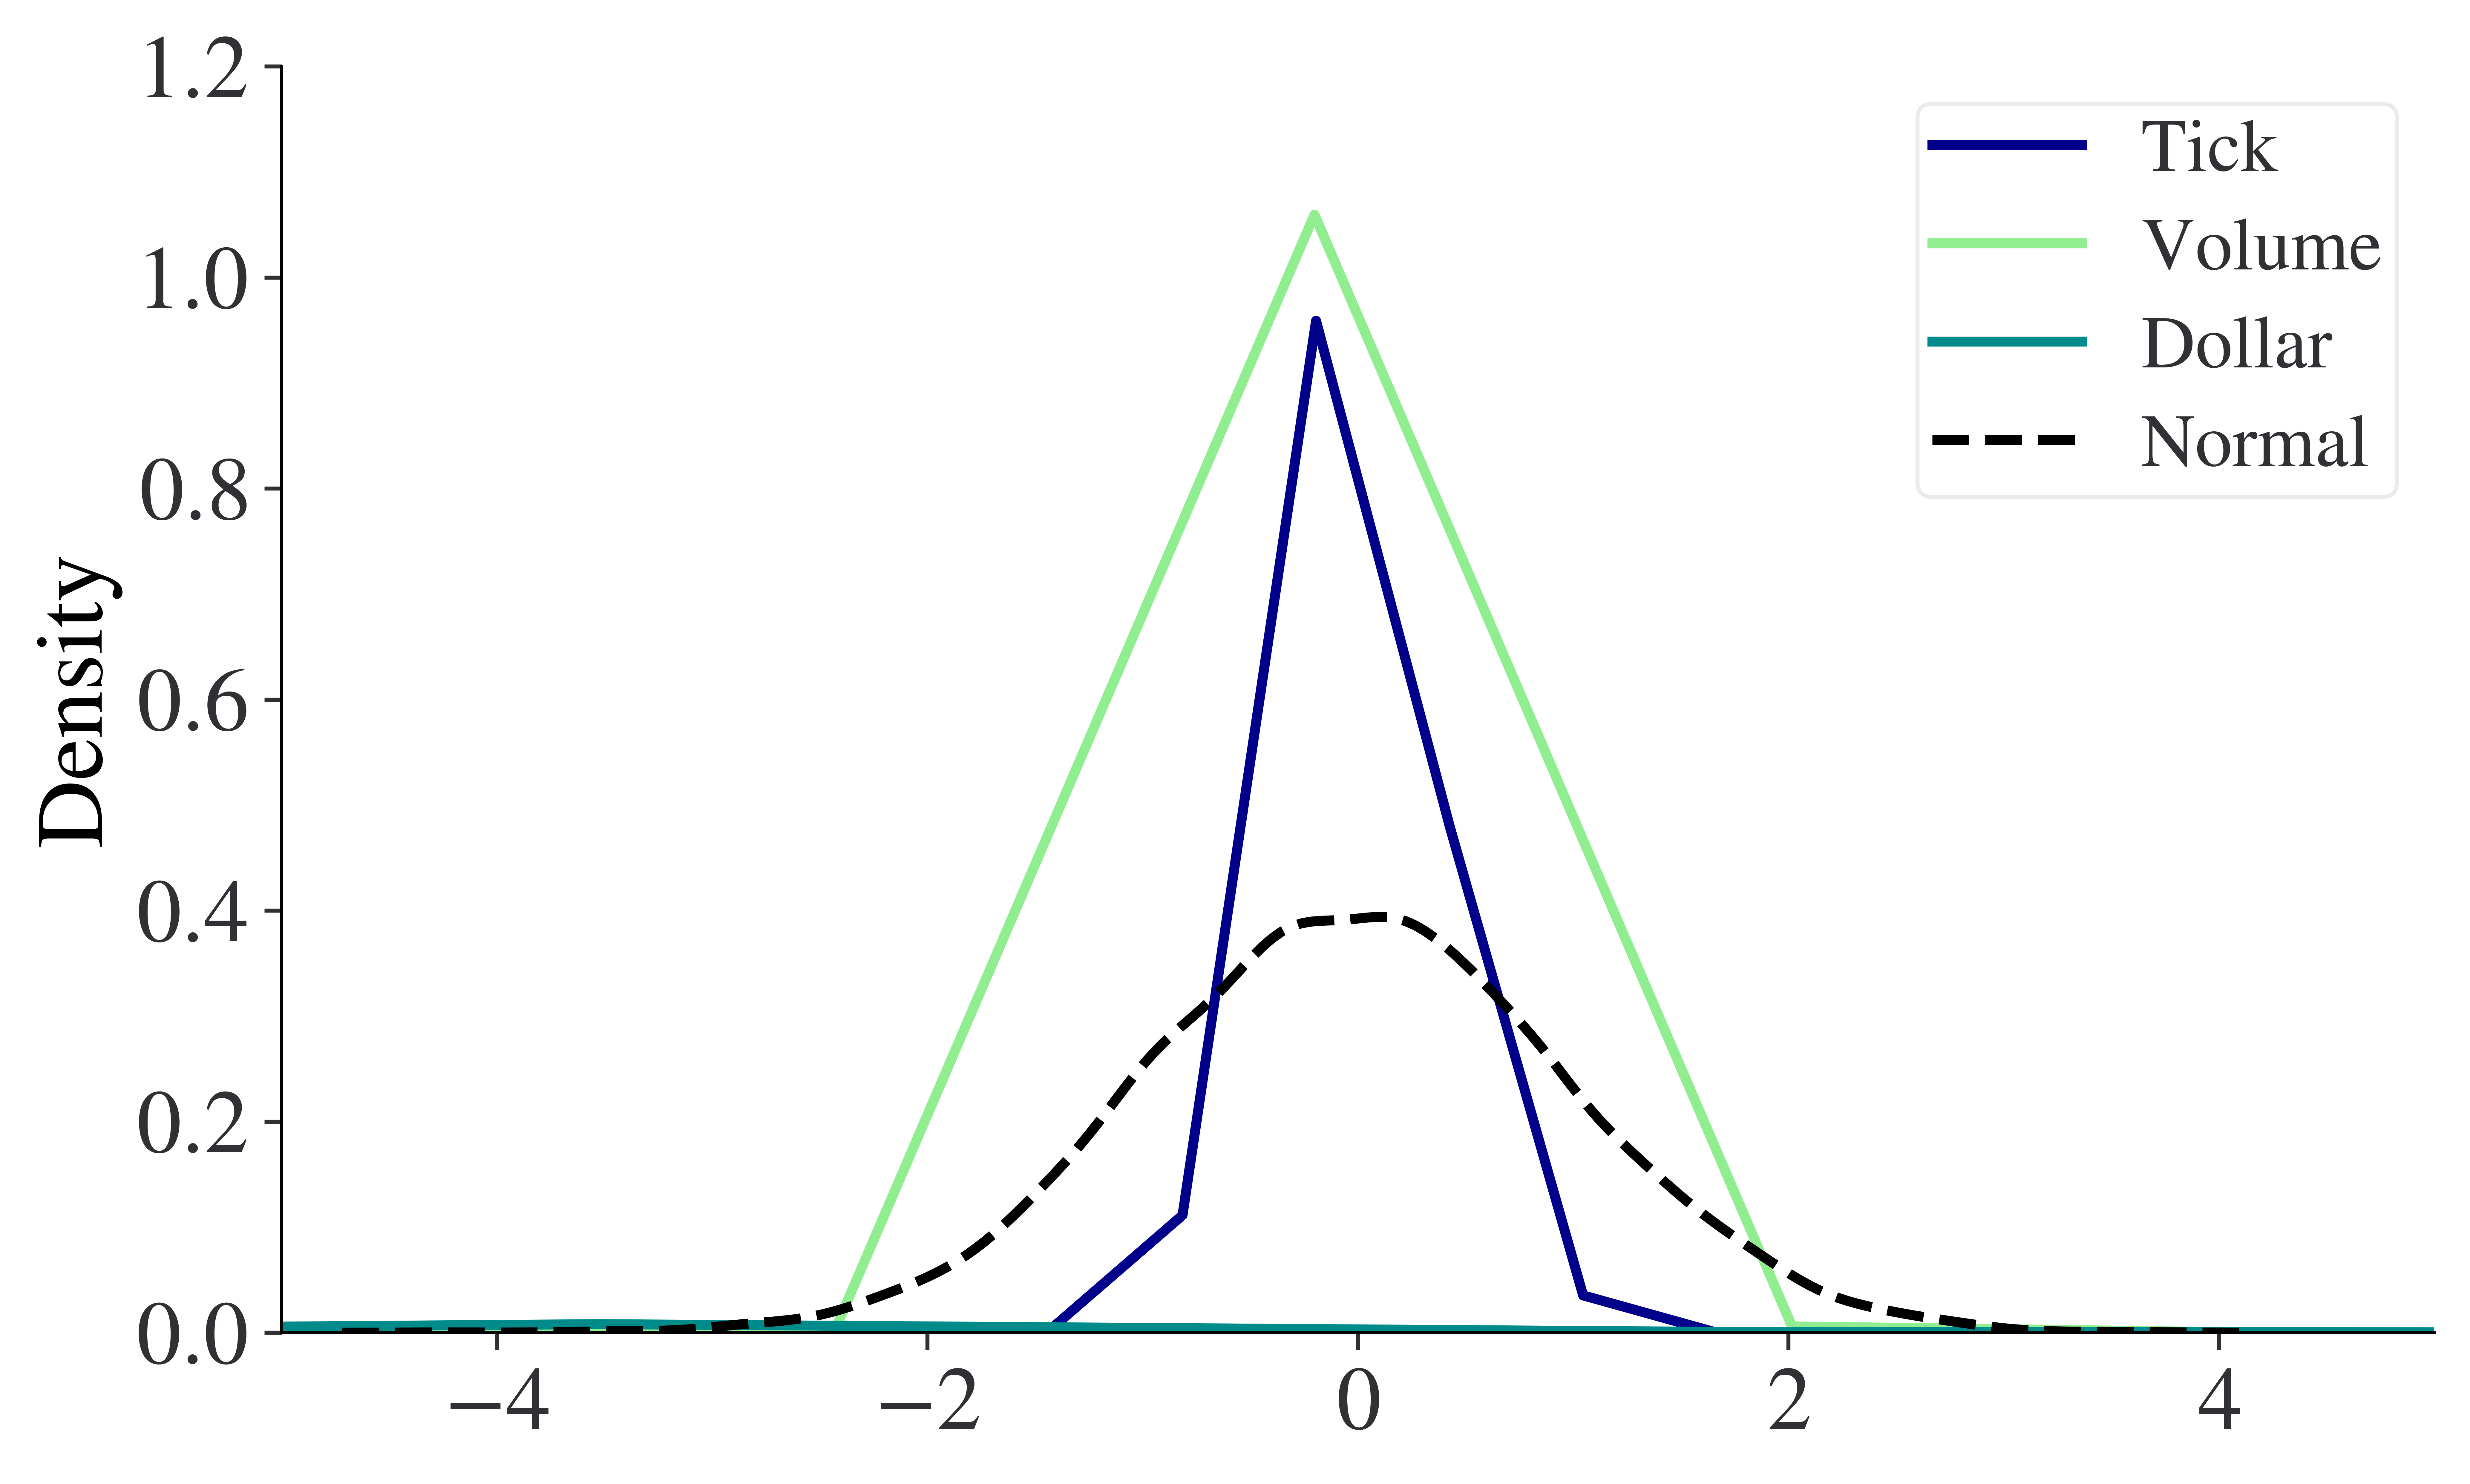

In [13]:
fig, ax = plt.subplots()
#sns.kdeplot(time_standard, label="Time", bw=0.30, color='darkred')
sns.kdeplot(tick_standard, 
            ax=ax,
            label="Tick", 
            bw=0.25,
            color='darkblue')
sns.kdeplot(volume_standard,
            ax=ax,
            label="Volume",
            bw=0.25,
            color='lightgreen')
sns.kdeplot(dollar_standard,
            ax=ax,
            label="Dollar",
            bw=0.25,
            linewidth=2,
            color='darkcyan')
sns.kdeplot(np.random.normal(size=len(tick_standard)),
            ax=ax,
            label="Normal",
            color='black',
            linewidth=2,
            linestyle="--")
plt.legend()
# _=ax.set_xticks(range(-5, 6))
_=ax.set_xlim(-5, 5)
file_name = str(symbol)+'_multiclocks_density_plot.png'
plt.savefig(os.path.join(figures_destination,file_name))
# 

In [20]:
df.columns.values

array(['BidSize_open', 'BidSize_high', 'BidSize_low', 'BidSize_close',
       'QuoteTime_open', 'QuoteTime_high', 'QuoteTime_low',
       'QuoteTime_close', 'type_x_open', 'type_x_high', 'type_x_low',
       'type_x_close', 'BestBid_open', 'BestBid_high', 'BestBid_low',
       'BestBid_close', 'TradeTime_open', 'TradeTime_high',
       'TradeTime_low', 'TradeTime_close', 'AskSize_open', 'AskSize_high',
       'AskSize_low', 'AskSize_close', 'time_y_open', 'time_y_high',
       'time_y_low', 'time_y_close', 'type_y_open', 'type_y_high',
       'type_y_low', 'type_y_close', 'BestAsk_open', 'BestAsk_high',
       'BestAsk_low', 'BestAsk_close', 'TradeSize_open', 'TradeSize_high',
       'TradeSize_low', 'TradeSize_close', 'type_open', 'type_high',
       'type_low', 'type_close', 'TradePrice_open', 'TradePrice_high',
       'TradePrice_low', 'TradePrice_close', 'TimeStamp_open',
       'TimeStamp_high', 'TimeStamp_low', 'TimeStamp_close',
       'TradeVolume_open', 'TradeVolume_high', 'Tr

In [126]:
garman_klass_vols_10 = defaultdict(dict)
garman_klass_vols_50 = defaultdict(dict)
garman_klass_vols_100 = defaultdict(dict)

dateIdx =2
barIdx =1
for dateIdx in range(0,len(dates)):
    for barIdx in range(0, len(bars_keys)):
        df =bars_dicts[dates[dateIdx]][bars_keys[barIdx]]

        garman_klass_vols_10[bars_keys[barIdx]][dateIdx]  =volatilityEstimation(df).garmanKlass(trading_periods=10)
        garman_klass_vols_50[bars_keys[barIdx]][dateIdx] = volatilityEstimation(df).garmanKlass(trading_periods=50)
        garman_klass_vols_100[bars_keys[barIdx]][dateIdx] = volatilityEstimation(df).garmanKlass(trading_periods=100)

/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = 

In [158]:
bar_idx = 2
garman_klass_vols_10[list(garman_klass_vols_10.keys())[bar_idx]]
garman_klass_vols_100[list(garman_klass_vols_100.keys())[bar_idx]]
garman_klass_vols_50[list(garman_klass_vols_50.keys())[bar_idx]]

{0: volume_bucket
 20.0        0.000139
 21.0        0.000139
 22.0        0.000116
 23.0        0.000087
 24.0        0.000072
               ...   
 101678.0    0.000015
 101679.0    0.000015
 101680.0    0.000015
 101681.0    0.000013
 101682.0    0.000013
 Length: 66703, dtype: float64,
 1: volume_bucket
 20.0       0.000139
 21.0       0.000139
 22.0       0.000116
 23.0       0.000087
 24.0       0.000072
              ...   
 32069.0    0.000141
 32070.0    0.000141
 32071.0    0.000140
 32072.0    0.000140
 32073.0    0.000140
 Length: 84876, dtype: float64,
 2: volume_bucket
 20.0       0.000139
 21.0       0.000139
 22.0       0.000116
 23.0       0.000087
 24.0       0.000072
              ...   
 48791.0    0.000075
 48792.0    0.000088
 48793.0    0.000089
 48794.0    0.000091
 48795.0    0.000091
 Length: 119895, dtype: float64}

## need some more work to do the plots for volatilities

In [227]:
dateIdx = 0
barIdx = 0
df =bars_dicts[dates[dateIdx]][bars_keys[barIdx]]
print(bars_keys[barIdx])

arrival_rates = volatilityEstimation(df).arrival_rates()

tick


/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


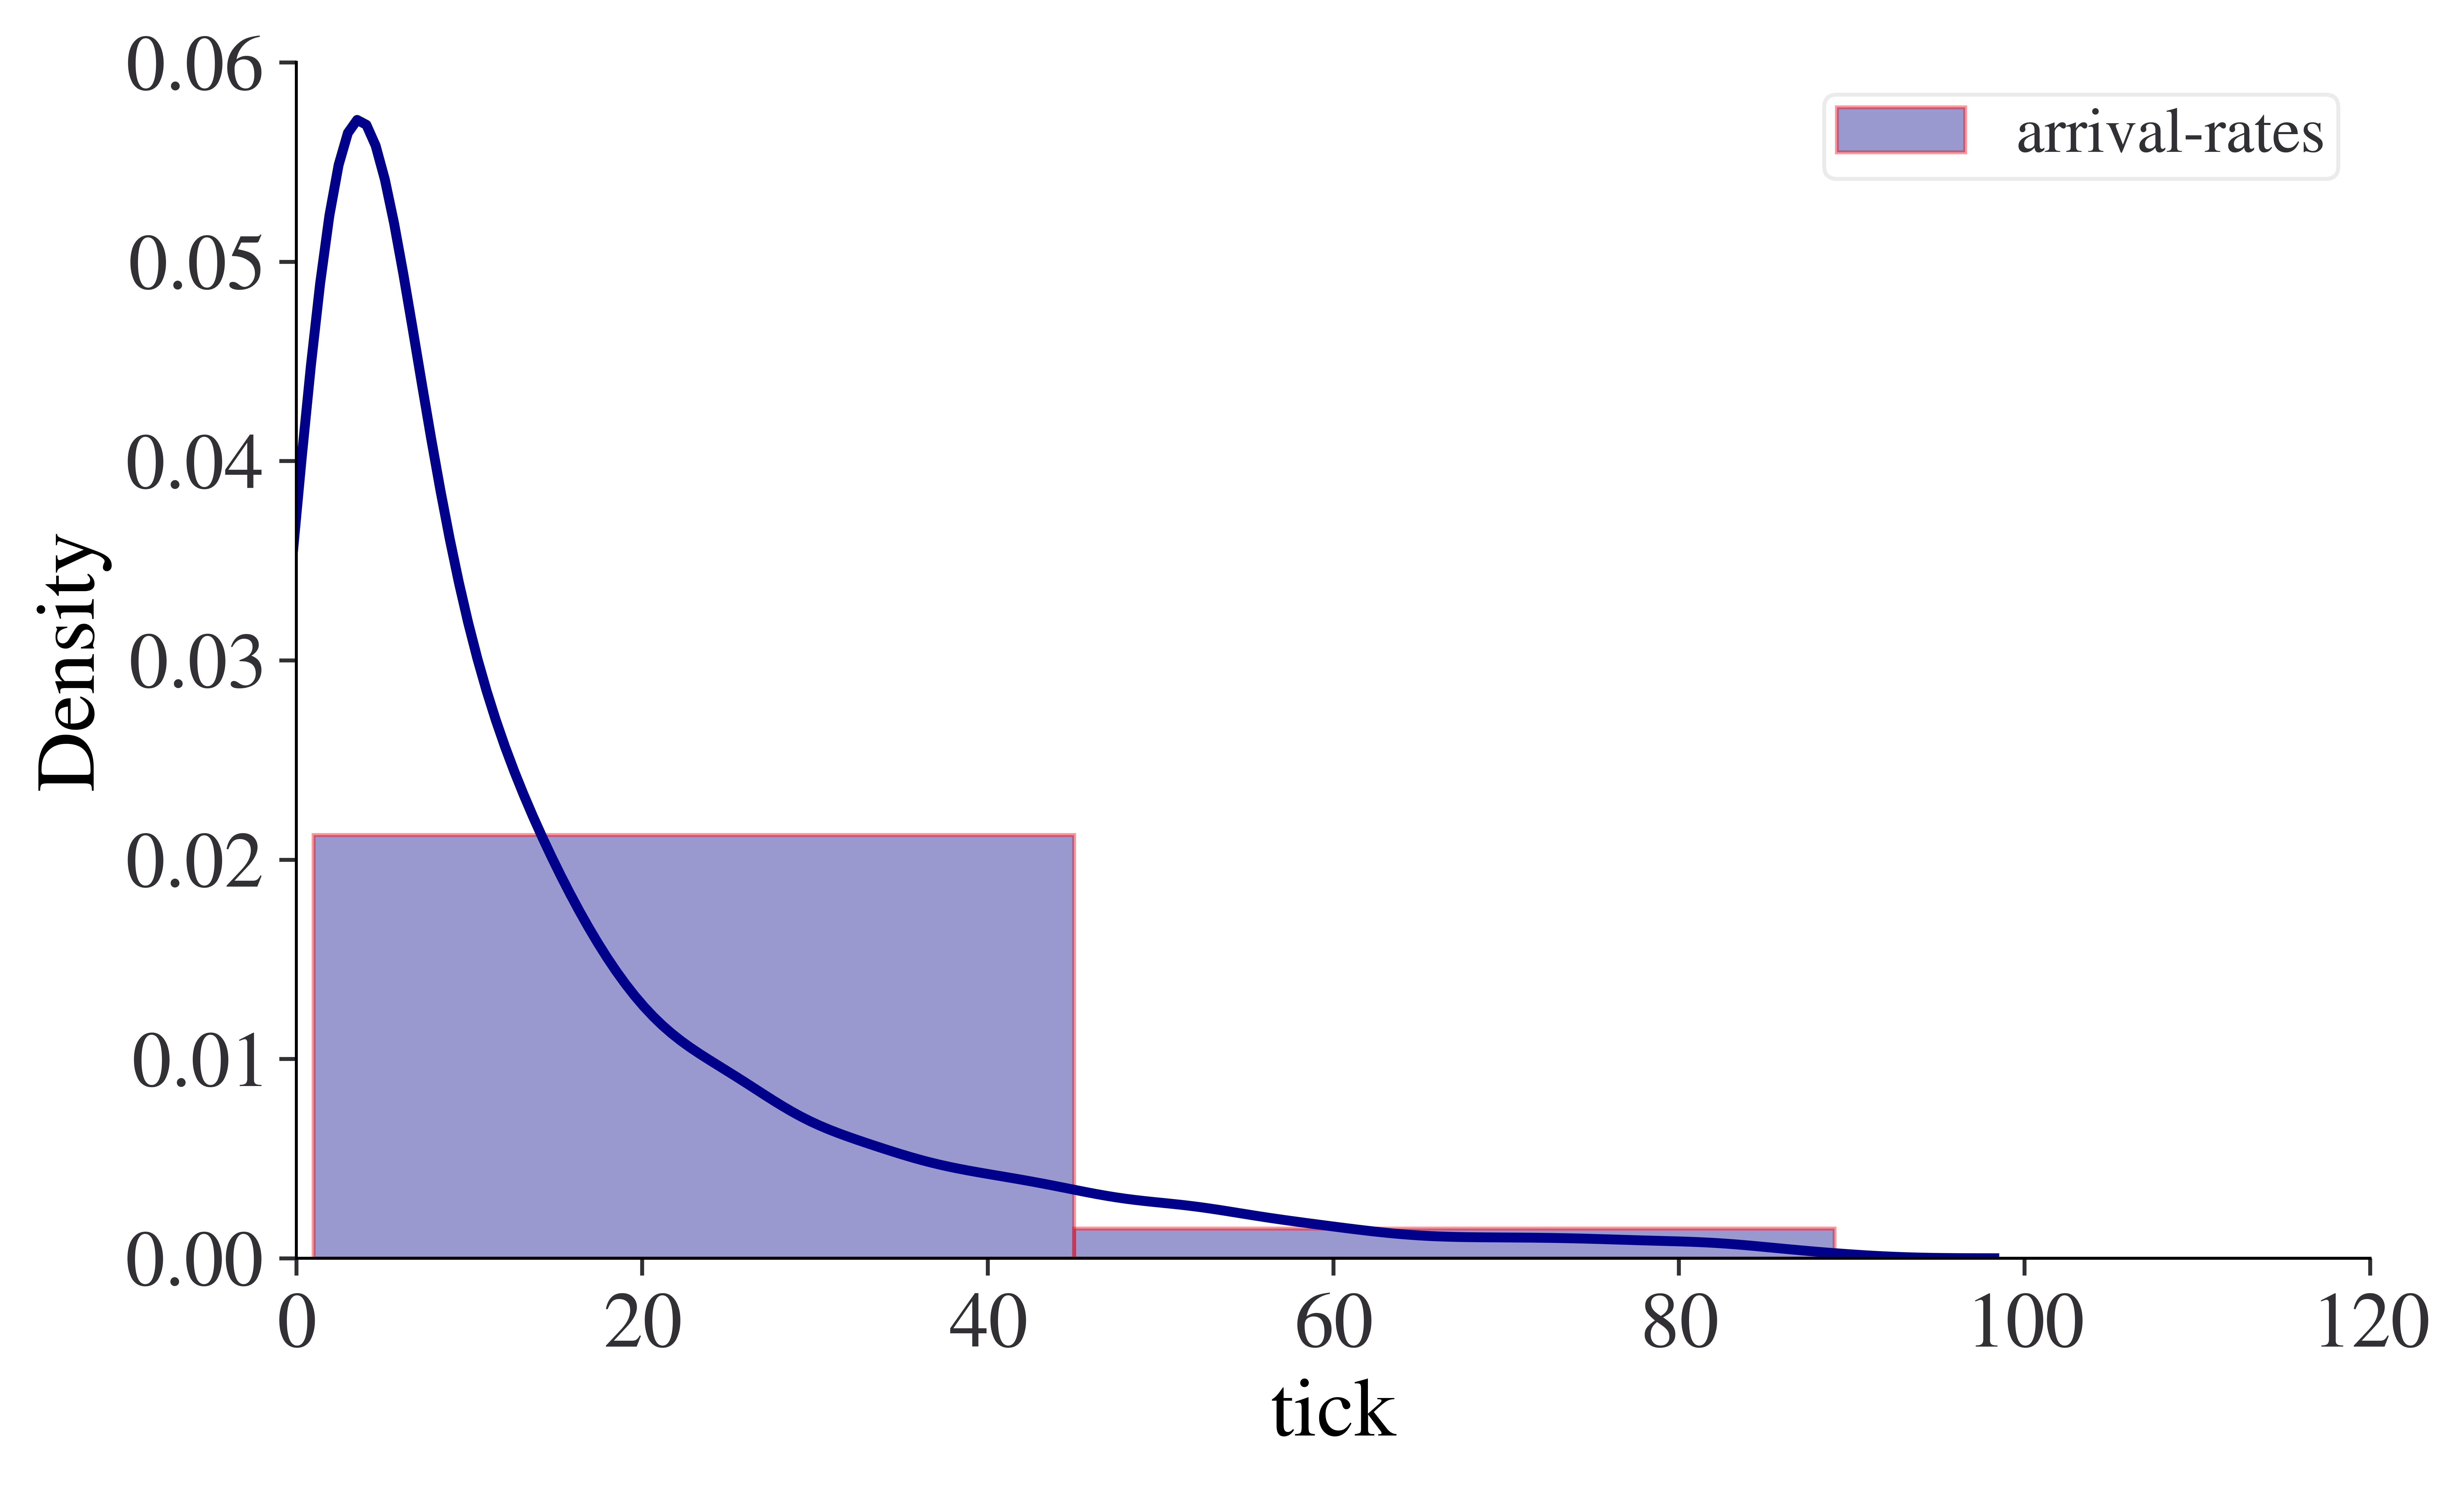

In [228]:
arrival_ratesg1 =sns.distplot(arrival_rates, hist=True, kde=True, 
             bins=int(2), color = 'darkblue', 
             hist_kws={'edgecolor':'red'},
             kde_kws={'linewidth': 2}, 
                label="arrival-rates")
# g2 =sns.distplot(garman_klass_vol_50, hist=True, kde=True, 
#              bins=int(200/5), color = 'green', 
#              hist_kws={'edgecolor':'lightblue'},
#              kde_kws={'linewidth': 2},
#                 label="50-trading ticks")
# plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.legend()
_=plt.xlim(left =0)
file_name = str(symbol)+str(bars_keys[barIdx])+'_arrival_rates_plot.png'
plt.savefig(os.path.join(figures_destination,file_name))
_=plt.xlabel( str(bars_keys[barIdx])) #y label

In [183]:
## cross-correlation

In [229]:
all_columns = list(df.columns.values)
# columns  = ['open_close_returns', 'GK_vol', 'volumePerTrade', 'realised_skew', 'realised_kurt',
#         'time_stamp', 'arrival_rates']
# df_select = df_choice[columns]

In [230]:
class_instance_ = volatilityEstimation(df)

In [287]:
# all_columns

In [251]:
# all_columns

In [289]:
df_choice = pd.DataFrame()
df_choice['open_close_returns'] = df.micro_price_close /df.micro_price_open -1 
df_choice['GK_vol'] = class_instance_.garmanKlass(trading_periods= 10)
rs, rk =class_instance_.realised_skewness_kurtosis(10)
df_choice['realised_skew'] = rs
df_choice['realised_kurt'] = rk
df_choice['traded_volume'] = df.TradeVolume_close 
df_choice['BestBidMedian'] = df[['BestBid_open',
 'BestBid_high',
 'BestBid_low',
 'BestBid_close']].median(axis=1)
df_choice['BestAskMedian'] = df[['BestAsk_open', 'BestAsk_high', 'BestAsk_low', 'BestAsk_close']].median(axis=1)
df_choice['book_pressure_simple'] = (df_choice.BestAskMedian - df_choice.BestBidMedian) / (df_choice.BestAskMedian + df_choice.BestBidMedian)
df_choice['trade_imbalance_ohlc_nml'] = (df.TradeSize_open - df.TradePrice_close) / (df.TradeSize_open + df.TradePrice_close)
df_choice['jump_measure'] = class_instance_.relative_jump_measure(10)
df_choice['jumps_test'] = class_instance_.jumps_test(10)
# need to add more here

df_choice['time_stamp'] = df_choice.index.values





/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [284]:

colormap = plt.cm.RdBu
from scipy.cluster import hierarchy as hc

In [306]:
df_select =df_choice[['open_close_returns', 'GK_vol', 'realised_skew', 'realised_kurt',
       'traded_volume', 'book_pressure_simple', 'trade_imbalance_ohlc_nml', 'jump_measure']]
df_select['time_stamp'] = df_select.index.values

/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [316]:
NON_DER =['time_stamp']
df_shifted =df_derived_by_shift(df_select, 1, NON_DER)


In [352]:
15*1.41

21.15

In [345]:
df_shifted =df_shifted.dropna()
df_shifted = df_shifted.drop(columns =['time_stamp'])

In [356]:
sns.set_context("paper", rc={"font.size":54,"axes.titlesize":26,"axes.labelsize":20}) 

sns.set(rc={'figure.figsize':(22,15)})
mask = np.zeros_like(df_shifted.corr())
mask[np.triu_indices_from(mask)] = True



svm = sns.heatmap(df_shifted.corr(), mask=mask, linewidths=0.3,vmax=1.0, 
            square=False, cmap=colormap, linecolor='white', annot=True, fmt = ".1%")
# file_name = 'cross_correlation_two.png'
# plt.savefig(os.path.join(figures_destination,file_name))
plt.legend()
plt.show()

No handles with labels found to put in legend.


In [348]:
df_shifted.corr()

open_close_returns    GK_vol  realised_skew  realised_kurt  traded_volume  book_pressure_simple  trade_imbalance_ohlc_nml  jump_measure  open_close_returns_1  GK_vol_1  realised_skew_1  realised_kurt_1  traded_volume_1  book_pressure_simple_1  trade_imbalance_ohlc_nml_1  jump_measure_1
open_close_returns                    1.000000 -0.014140      -0.028469      -0.042526      -0.011591             -0.024926                  0.031308     -0.037397             -0.304875 -0.014677        -0.034562        -0.041158         0.013526               -0.055715                   -0.017203        0.023281
GK_vol                               -0.014140  1.000000       0.607366       0.302651      -0.039066              0.026173                 -0.022714     -0.242681             -0.012291  0.982639         0.614303         0.307796        -0.038185                0.015221                   -0.023692       -0.237786
realised_skew                        -0.028469  0.607366       1.000000       0.689541      -0.023279              0.025924                 -0.015093     -0.007321             -0.031700  0.578531         0.917184         0.644388        -0.026758                0.019711                   -0.021801       -0.004426
realised_kurt                        -0.042526  0.302651       0.689541       1.000000      -0.015406              0.014393                 -0.009480     -0.019440             -0.051188  0.285765         0.644051         0.935138        -0.015759                0.012994                   -0.013156       -0.015063
traded_volume                        -0.011591 -0.039066      -0.023279      -0.015406       1.000000              0.008846                  0.269581      0.035054             -0.020235 -0.039489        -0.026415        -0.014516         0.323294                0.003561                    0.076566        0.007855
book_pressure_simple                 -0.024926  0.026173       0.025924       0.014393       0.008846              1.000000                 -0.012773     -0.026327              0.055854  0.037867         0.028733         0.014899         0.012568                0.510725                   -0.000801       -0.015986
trade_imbalance_ohlc_nml              0.031308 -0.022714      -0.015093      -0.009480       0.269581             -0.012773                  1.000000      0.003606             -0.009855 -0.021949        -0.010106        -0.009419         0.777012               -0.009588                    0.328064        0.039264
jump_measure                         -0.037397 -0.242681      -0.007321      -0.019440       0.035054             -0.026327                  0.003606      1.000000             -0.008164 -0.261739        -0.136703        -0.042879         0.006168                0.002442                    0.005981        0.493976
open_close_returns_1                 -0.304875 -0.012291      -0.031700      -0.051188      -0.020235              0.055854                 -0.009855     -0.008164              1.000000 -0.012958        -0.028062        -0.042416        -0.010636               -0.025723                    0.032570       -0.037603
GK_vol_1                             -0.014677  0.982639       0.578531       0.285765      -0.039489              0.037867                 -0.021949     -0.261739             -0.012958  1.000000         0.607141         0.302298        -0.038137                0.025240                   -0.021576       -0.242813
realised_skew_1                      -0.034562  0.614303       0.917184       0.644051      -0.026415              0.028733                 -0.010106     -0.136703             -0.028062  0.607141         1.000000         0.689459        -0.023103                0.025530                   -0.015069       -0.007393
realised_kurt_1                      -0.041158  0.307796       0.644388       0.935138      -0.014516              0.014899                 -0.009419     -0.042879             -0.042416  0.302298         0.689459         1.000000        -0.015399  

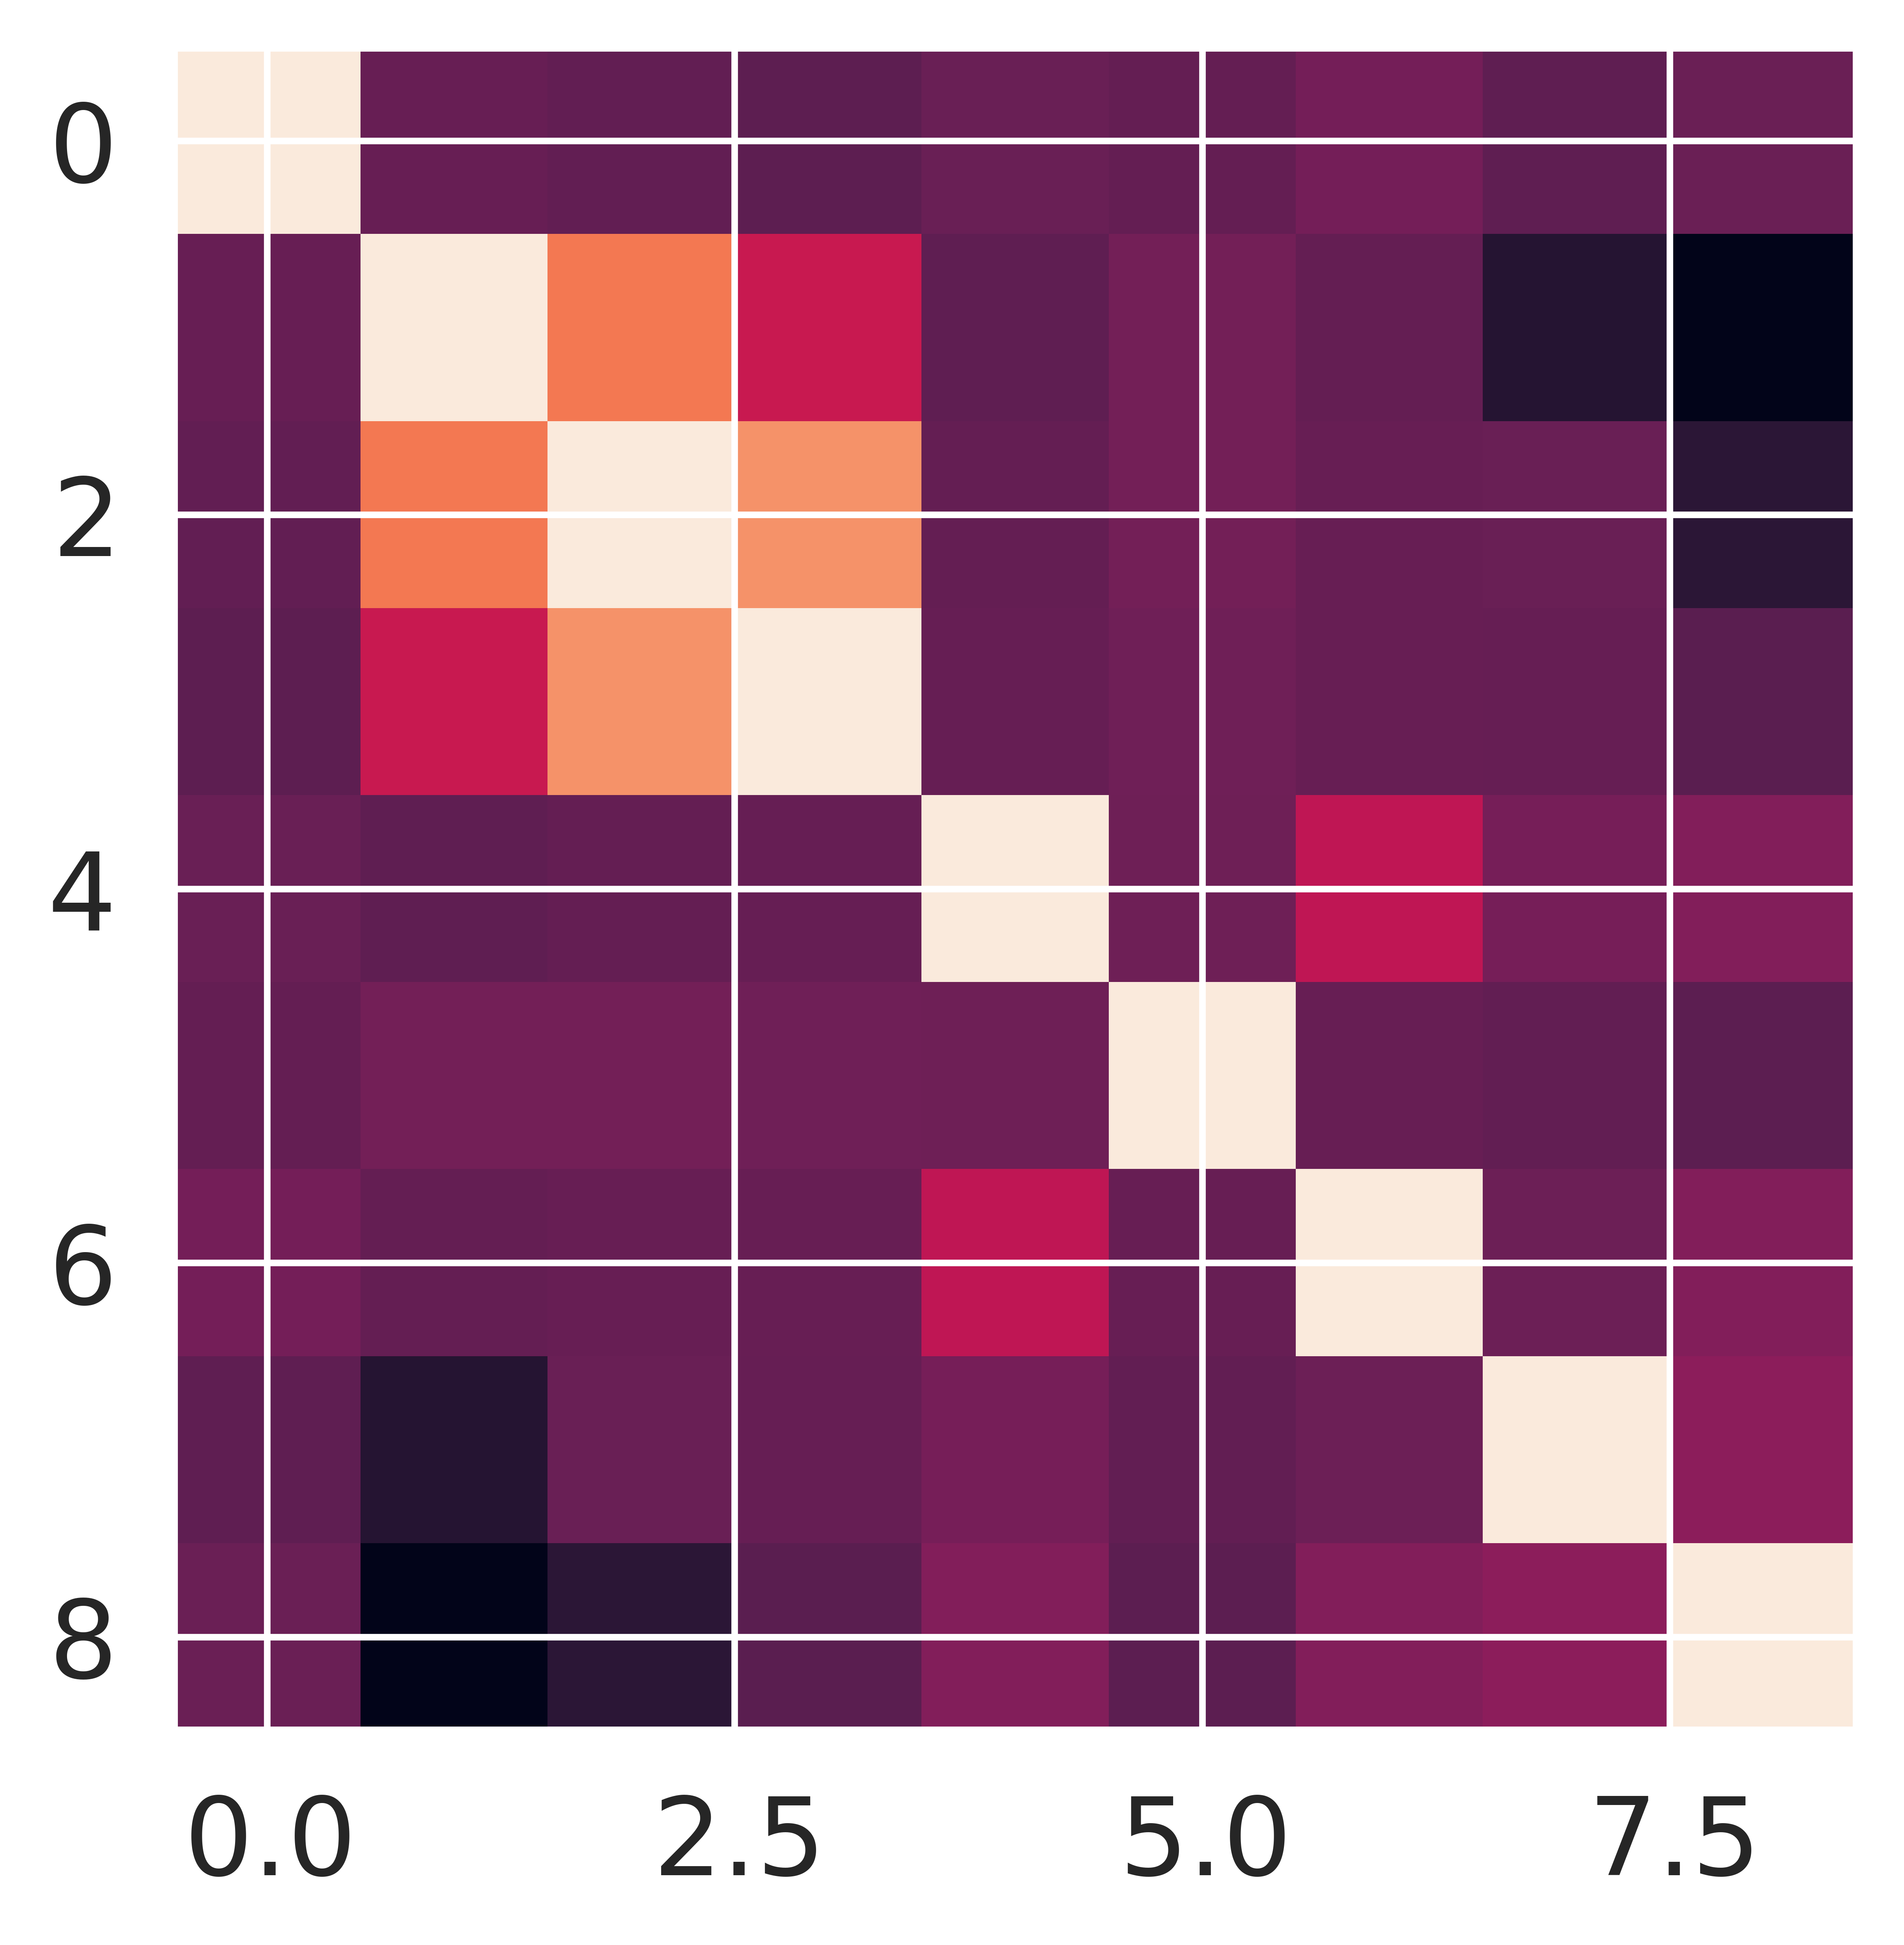

In [320]:
correl = df_select.corr()
fig, ax = plt.subplots()
im = ax.imshow(correl)
# _ = ax.set_xticks(np.arange(len(df_shifted.columns.values)))
# _= ax.set_xticklabels(df_select.columns.values, fontsize = 5)
# _= ax.set_yticklabels(df_select.columns.values, fontsize =5 )

# _ =plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")

In [ ]:
fig, ax = plt.subplots()

im, cbar = heatmap(harvest, vegetables, farmers, ax=ax,
                   cmap="YlGn", cbarlabel="harvest [t/year]")
texts = annotate_heatmap(im, valfmt="{x:.1f} t")

fig.tight_layout()
plt.show()

In [325]:
df_select = df_select.fillna(0)


In [368]:
df_select =df_select.drop(columns=['time_stamp'])

In [369]:
variables = list(df_select.columns.values)

In [377]:
correl = np.around(np.array(df_select.corr()), 5)

In [389]:
import matplotlib
plt.style.use(os.path.join('/home/ak/.config/matplotlib','latexstyle3.mplstyle'))
fig, ax = plt.subplots()

im, cbar = heatmap(correl, variables , variables , ax=ax,
                   cmap="YlGn")
_= ax.set_yticklabels(variables,fontsize = 15)

_= ax.set_xticklabels(variables, rotation = -65, fontsize = 15)

# texts = annotate_heatmap(im, valfmt="{x:.1f} t")
## to do: drop time-stamp

In [358]:
import multiprocessing as mp

def my_func(x):
  print(x**x)

def main():
  pool = mp.Pool(mp.cpu_count())
  result = pool.map(my_func, [4,2,3])



In [379]:
main()

427256




In [386]:
import multiprocessing as mp

def my_func(x):
    print(mp.current_process())
    return x**x

def main():
    pool = mp.Pool(mp.cpu_count())
    result = pool.map(my_func, [4,2,3,5,3,2,1,2])
    result_set_2 = pool.map(my_func, [4,6,5,4,6,3,23,4,6])
    
    print(result)
    print(result_set_2)



In [390]:
from time import sleep
import multiprocessing as mp

def f_sleep(x):
    sleep(2)
    return x*x


def f(x):
    return x*x


if __name__ == '__main__':
  
  with mp.Pool(processes=7) as pool:  # default number of processes: os.cpu_count()
    
    print(pool.map(f, range(10)))

    for i in pool.imap_unordered(f, range(10)):
        print(i)
        
    
    # run tasks asynchronously
    tasks = []   
    
    for i in range(10):
        tasks.append(pool.apply_async(f_sleep, args=(i, )))
    
    # some other code

    # timeout if fetching results takes too long
    for i in tasks:
        print(i.get(timeout=3))

In [391]:

    df = testClass.load_and_format_data()[str(date)]
    input_dict = testClass.get_bars(df)
    tick_bar_df = testClass.get_concat_data(testClass._bars_dict)['tick_bars']
    volume_bar_df = testClass.get_concat_data(testClass._bars_dict)['volume_bars']
    usd_volume_bar_df = testClass.get_concat_data(testClass._bars_dict)['usd_volume_bars']
    calendar_bar_df = testClass.get_concat_data(testClass._bars_dict)['calendar_bars']
    vr = returns(volume_bar_df.micro_price_close).replace([np.inf, -np.inf], 0)  # volume
    tr = returns(tick_bar_df.micro_price_close).replace([np.inf, -np.inf], 0)  # tick
    dr = returns(usd_volume_bar_df.micro_price_close).dropna().replace([np.inf, -np.inf], 0)  # usd volume
    df_ret = returns(calendar_bar_df.micro_price_close).dropna().replace([np.inf, -np.inf],
                                                            

### playing with multiprocessing 

In [395]:
def produce_info_clock_files(date):
    bar_returns = dict()
    bars_dicts = defaultdict(dict)
    tick_bar_dfs = []
    volume_bar_dfs = []
    usd_volume_bar_dfs = []
    calendar_bar_dfs = []

    df = testClass.load_and_format_data()[str(date)]
    input_dict = testClass.get_bars(df)
    tick_bar_df = testClass.get_concat_data(testClass._bars_dict)['tick_bars']
    volume_bar_df = testClass.get_concat_data(testClass._bars_dict)['volume_bars']
    usd_volume_bar_df = testClass.get_concat_data(testClass._bars_dict)['usd_volume_bars']
    calendar_bar_df = testClass.get_concat_data(testClass._bars_dict)['calendar_bars']
    vr = returns(volume_bar_df.micro_price_close).replace([np.inf, -np.inf], 0)  # volume
    tr = returns(tick_bar_df.micro_price_close).replace([np.inf, -np.inf], 0)  # tick
    dr = returns(usd_volume_bar_df.micro_price_close).dropna().replace([np.inf, -np.inf], 0)  # usd volume
    df_ret = returns(calendar_bar_df.micro_price_close).dropna().replace([np.inf, -np.inf], 0)  # calendar
    bar_returns[date] = {'tick': tr,
                         'volume': vr,
                         'dollar': dr,
                         'calendar': df_ret}
    bars_dicts[date]['tick'] = tick_bar_df
    bars_dicts[date]['volume'] = volume_bar_df
    bars_dicts[date]['calendar'] = calendar_bar_df
    bars_dicts[date]['dollar'] =  usd_volume_bar_df
    
    
    
    return bar_returns, bar_dicts


In [407]:

if __name__ == '__main__':

    symbolIdx = 2

    symbol = sorted(symbols)[symbolIdx]
    print(symbol)
    quotesFileCh = os.path.join(dataFolder, quotes[symbolIdx])
    tradesFileCh = os.path.join(dataFolder, trades[symbolIdx])

    # get common Dates
    quotesDates = sorted([f.split(".csv")[0] for f in os.listdir(quotesFileCh)])
    tradesDates = sorted([f.split(".csv")[0] for f in os.listdir(tradesFileCh)])
    intersectionDates = list(set(quotesDates).intersection(tradesDates))

    trades_cols = ['size', 'time', 'type', 'value']

    # params for the clocks

    calendar_resample_freq = "300S"
    trade_volume_width = 100
    ticks_width = 100
    usd_volume_width = 100
    dates_choice = intersectionDates

    testClass = DataLoader(data_location=dataFolder,
                           symbol=symbol,
                           dates=dates_choice,
                           use_columns=trades_cols,
                           calendar_resample=calendar_resample_freq,
                           trade_volume_width=trade_volume_width,
                           ticks_width=ticks_width,
                           usd_volume_width=usd_volume_width)

    hash_of_file = "_".join(
        (str(symbol), "volume_width", str(trade_volume_width), "calendar_resample", str(calendar_resample_freq)))

    # load data
    input_dict = testClass.load_and_format_data()


    dates = list(input_dict.keys())



In [ ]:
# with multiprocessing.Pool(processes=6) as process_pool:
#     process_pool.starmap(produce_mfdfa_quantities,  itertools.product(idx, key))


In [402]:
experimentsDestination = '/media/ak/T7/MFDFA Experiments'
symbolLocation = os.path.join(experimentsDestination, symbol)


In [405]:
experimentsDestination

In [408]:
dates